In this notebook VGG16 (K. Simonyan and A. Zisserman, “Very Deep Convolutional Networks for Large-Scale Image Recognition”) is recreated to classify musical instruments typical for a rock band. Data has been gathered with help of a script provided in the repository. It has been verified and split randomly into different directories in accordance with requirements for [Tensorflow Datasets Requirements](https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder). To check files consistency programs such as jpeginfo can be used; digikam is useful to detect duplicates. In this project the model will be first built and trained from scratch and later transfer learning from already pre-trained VGG16 model will be applied. This notebook has been run on Google Colab.

### Import libraries

In [ ]:
import tensorflow as tf 

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 12.5MB/s 


In [ ]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix

### Load dataset
We import the dataset from google drive. First we copy its archive and then we extract it.

In [ ]:
!cp ./drive/MyDrive/instruments.tar.gz ./instruments.tar.gz

In [ ]:
!ls

drive  instruments.tar.gz  sample_data


In [ ]:
import tarfile

tar_file = "/content/instruments.tar.gz"
tar = tarfile.open(tar_file, "r:gz")
tar.extractall()
tar.close()

In [ ]:
!ls ./instruments

test  train  validation


We make use out of tensorflow datasets to import and preprocess our data.

In [ ]:
data_dir = '/content/instruments'
builder = tfds.ImageFolder(data_dir)
info = builder.info
print(info)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=4825,
    splits={
        'test': 480,
        'train': 3865,
        'validation': 480,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



Data has been randomized and split before so now we have only to import it.

In [ ]:
train_ds_org = builder.as_dataset(split='train', as_supervised=True, shuffle_files=True)
valid_ds_org = builder.as_dataset(split='validation', as_supervised=True)
test_ds_org = builder.as_dataset(split='test', as_supervised=True)

Let's see some of the images.

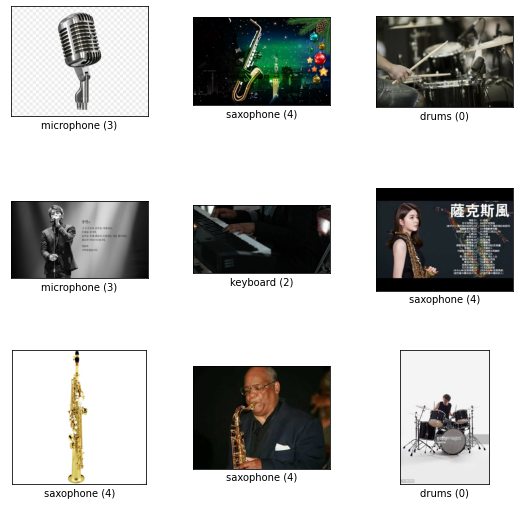

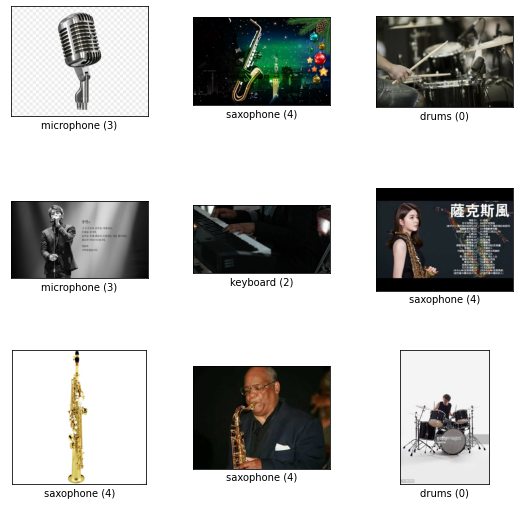

In [ ]:
tfds.show_examples(train_ds_org, builder.info)

Images with various lighting, background and elements positions can be observed.  
### Data preprocessing
We define preprocessing functions that will help to prevent overfitting.

In [ ]:
batch_size = 128

@tf.function
def transform_inp(image, label):
  image = tf.image.resize_with_pad(image, 224, 224)
  return tf.cast(image, tf.float32)/255., tf.one_hot(label, depth=5)

@tf.function
def transform_aug_inp(image, label):
  image = tfa.image.rotate(image, tf.constant((np.pi/18)*np.random.uniform(-1.,1.)))
  #image = tf.image.random_crop(image, size=[224, 224, 3])
  image = tf.image.resize_with_pad(image, 300, 300)
  image = tf.image.random_crop(image, size=[224, 224, 3])
  #image = tf.image.resize(image, size=[224, 224])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
  return tf.cast(image, tf.float32)/255., tf.one_hot(label, depth=5)

train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).batch(batch_size)

Let's see how preprocessed images look like.

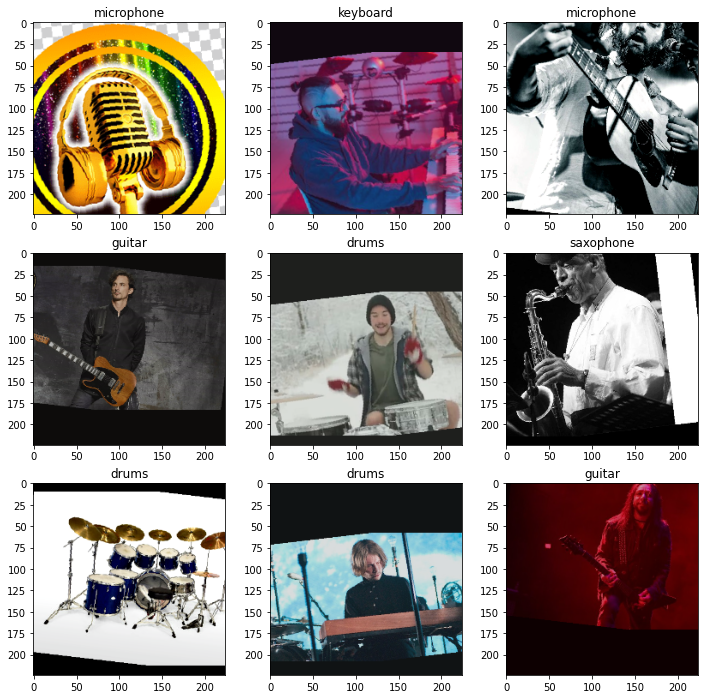

In [ ]:
get_label_name = info.features['label'].int2str

plt.figure(figsize=(12,12)) 
for batch in train_ds.take(1):
  for i in range(9):
    img, label = batch[0][i], batch[1][i]
    plt.subplot(3,3,i+1)
    plt.title(get_label_name(np.argmax(label)))
    plt.imshow(img)
plt.show()

Preprocessed images look reasonable. There is some padding but it is inevitable when using images of a random size.

### Model
We define our model following VGG16 architecture.

In [ ]:
model = tf.keras.models.Sequential([
    
    #first budle (2 conv layers)
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),
                           padding='same', activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    #second budle (2 conv layers)
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    #third budle (3 conv layers)
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    #fifth bundle (3 conv layers)
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),  

    #fifth bundle (3 conv layers)
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),  
    
    #sixth fully connected bundle (13 conv layers + 3 dens)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

Let's check the model summary.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 256)      

### Defining the loss function and compiling the model

Here we define our optimizer, loss function, and necessary metrics. We will be using SGD as optimization algorithm and accuracy as the evaluation metrics.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              metrics=['accuracy'])

### Plotting function
We define plotting function to investigate the training of our model

In [ ]:
def plot_conv(hist):                     
    history_dict = hist.history
    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    epochs = range(1, len(train_acc) + 1)
    axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[0].plot(epochs, train_loss, c='orange', label='Training loss')
    axs[0].set_title('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    #axs[0].set_xscale('log')
    axs[0].legend()
    
    axs[1].plot(epochs, val_acc, 'b', label='Validation accuracy')
    axs[1].plot(epochs, train_acc, c='orange', label='Training accuracy')
    axs[1].set_title('Training and validation accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    #axs[1].set_xscale('log')
    axs[1].legend()
    plt.tight_layout()

    print("Final statistics")
    print("Training")
    print("Loss: {:.3f}  Accuracy: {:.3f}".format(train_loss[-1], train_acc[-1]))
    print("Validation")
    print("Loss: {:.3f}  Accuracy: {:.3f}".format(val_loss[-1], val_acc[-1]))

### Training

We train our model for 100 epochs to see how it performs.

Epoch 1/100
31/31 [==============================] - 122s 3s/step - loss: 1.6071 - accuracy: 0.2230 - val_loss: 1.6005 - val_accuracy: 0.2271
Epoch 2/100
31/31 [==============================] - 120s 3s/step - loss: 1.5988 - accuracy: 0.2293 - val_loss: 1.5999 - val_accuracy: 0.2271
Epoch 3/100
31/31 [==============================] - 121s 3s/step - loss: 1.6025 - accuracy: 0.2229 - val_loss: 1.5994 - val_accuracy: 0.2271
Epoch 4/100
31/31 [==============================] - 120s 3s/step - loss: 1.6032 - accuracy: 0.2161 - val_loss: 1.5983 - val_accuracy: 0.2333
Epoch 5/100
31/31 [==============================] - 120s 3s/step - loss: 1.5982 - accuracy: 0.2385 - val_loss: 1.5965 - val_accuracy: 0.2583
Epoch 6/100
31/31 [==============================] - 120s 3s/step - loss: 1.5934 - accuracy: 0.2364 - val_loss: 1.5895 - val_accuracy: 0.2604
Epoch 7/100
31/31 [==============================] - 120s 3s/step - loss: 1.5915 - accuracy: 0.2114 - val_loss: 1.5874 - val_accuracy: 0.2396
Epoch 

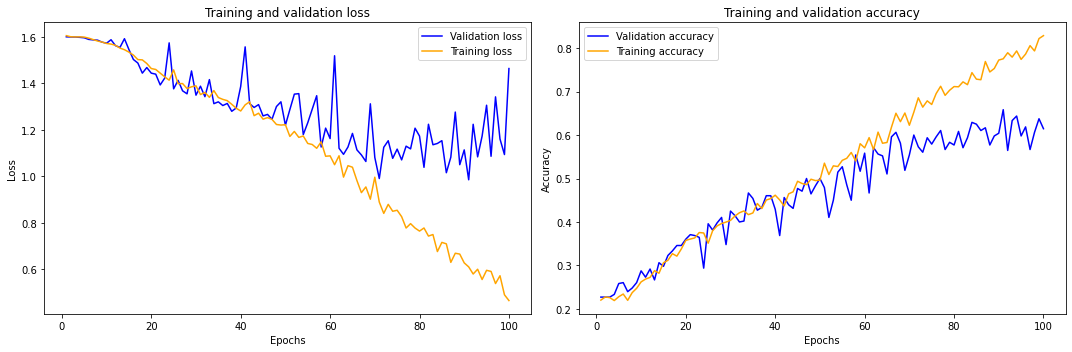

In [ ]:
base_hist = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds, 
    verbose = 1
)

plot_conv(base_hist)

Overfitting can be observed from around 20 epochs. To prevent it regularization could be applied combined with hyperparameters tunning. On the other hand, given that our data set is rather small it will be definetly more beneficial to apply transfer learning. 
### Transfer learning   
For that VGG16 will be used that was pre-trained on ImageNet. First, we freeze all VGG16 convulation weights and train only the added dense layers.

#### Dense layers only

In [ ]:
transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
transfer_model.trainable = False
transfer_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/50
31/31 [==============================] - 103s 3s/step - loss: 16.1215 - accuracy: 0.2028 - val_loss: 11.7577 - val_accuracy: 0.2271
Epoch 2/50
31/31 [==============================] - 103s 3s/step - loss: 6.1408 - accuracy: 0.2057 - val_loss: 4.9496 - val_accuracy: 0.1688
Epoch 3/50
31/31 [==============================] - 102s 3s/step - loss: 5.3261 - accuracy: 0.2021 - val_loss: 8.6875 - val_accuracy: 0.2208
Epoch 4/50
31/31 [==============================] - 102s 3s/step - loss: 10.3197 - accuracy: 0.2028 - val_loss: 12.4489 - val_accuracy: 0.1688
Epoch 5/50
31/31 [==============================] - 103s 3s/step - loss: 8.9530 - accuracy: 0.2085 - val_loss: 10.8372 - val_accuracy: 0.1688
Epoch 6/50
31/31 [==============================] - 103s 3s/step - loss: 8.4339 - accuracy: 0.2109 - val_loss: 7.0438 - val_accuracy: 0.2271
Epoch 7/50
31/31 [==============================] - 103s 3s/step - loss: 6.3488 - accuracy: 0.2031 - val_loss: 4.7327 - val_accuracy: 0.2271
Epoch 8/

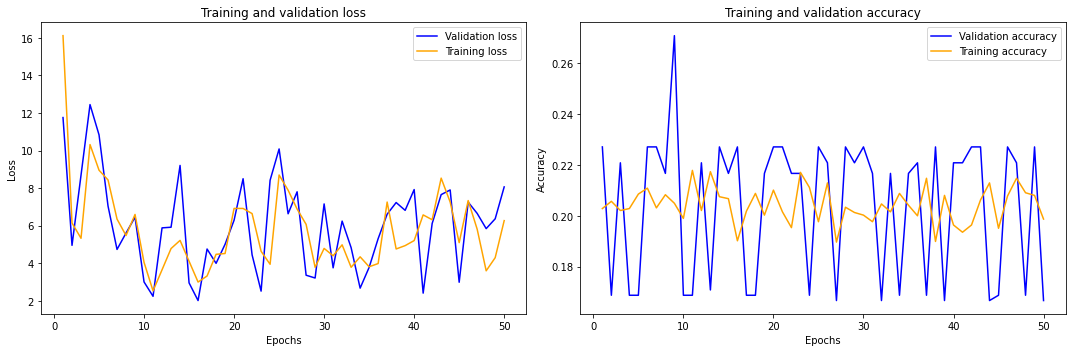

In [ ]:
transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 1
)

plot_conv(transfer_hist)

It seems that learning rate is too big and optimization oscilates instead of converging to the solution.

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 0.30

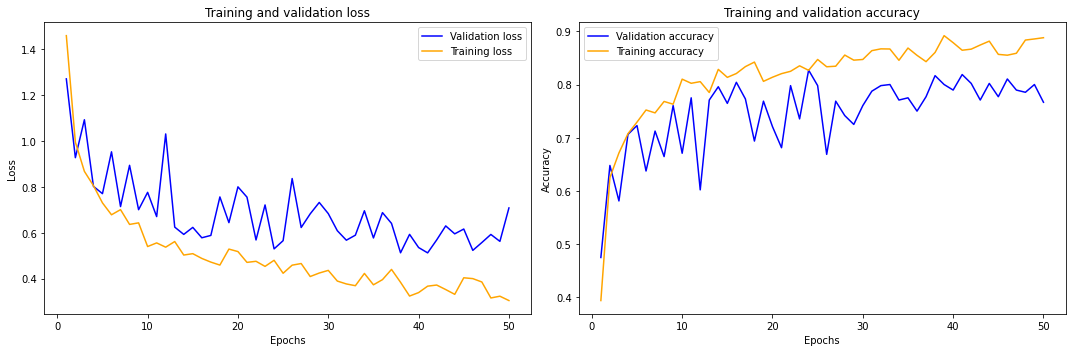

In [ ]:
transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
transfer_model.trainable = False
model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

Jumps have reduced but still a lower learning rate could be tried.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 0.499  Accuracy: 0.826
Validation
Loss: 0.606  Accuracy: 0.802


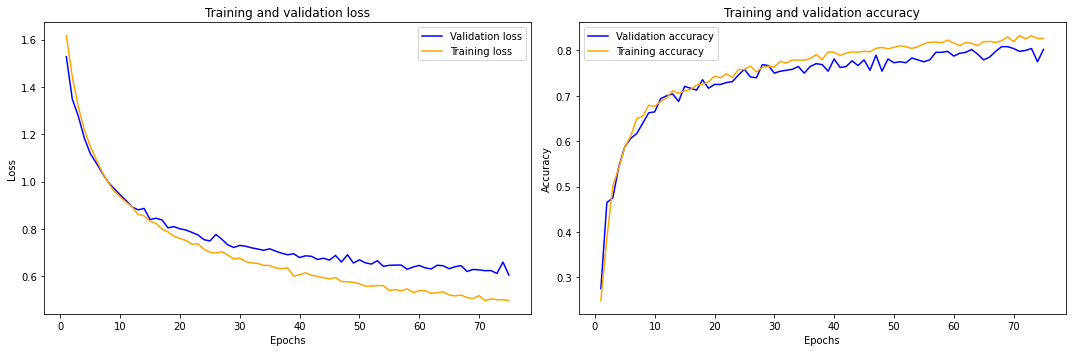

In [ ]:
transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
transfer_model.trainable = False
model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=75,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

It seems that it almost converged and the plots are much less jagged. We can also try decaying learning to take advantage of the fast learning at the the start and to prevent problems as optimization approaches the local optimium. For that we will use the piecewise constant scheduler.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 0.368  Accuracy: 0.878
Validation
Loss: 0.528  Accuracy: 0.825


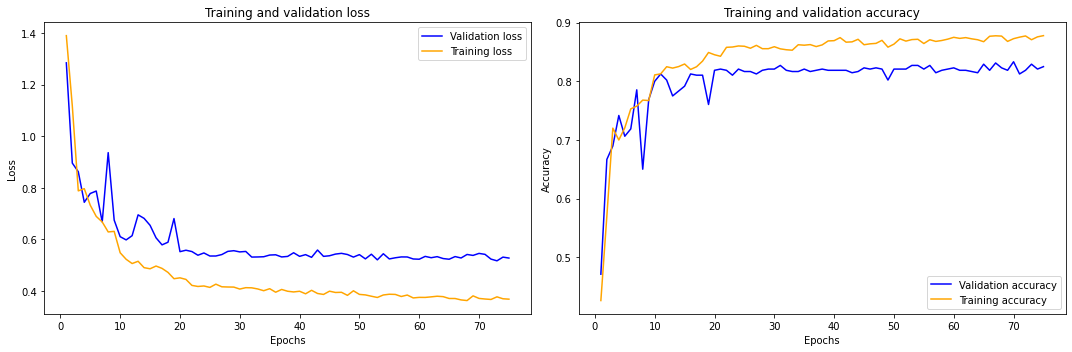

In [ ]:
num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
transfer_model.trainable = False
model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=75,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)


We can observe a plateau starting from around 25 epochs. It seems that these learning rate setting work well. Now let's try tuning the batch size.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 0.361  Accuracy: 0.875
Validation
Loss: 0.578  Accuracy: 0.777


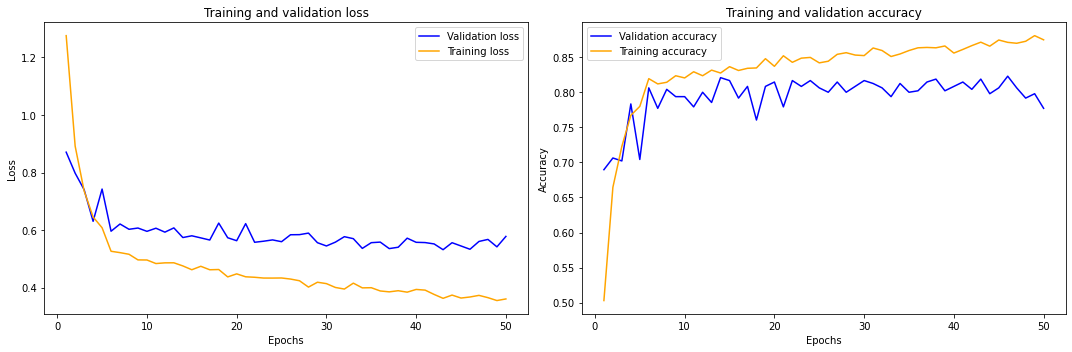

In [ ]:
batch_size = 32

train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/32)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
transfer_model.trainable = False
model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 0.374  Accuracy: 0.877
Validation
Loss: 0.551  Accuracy: 0.804


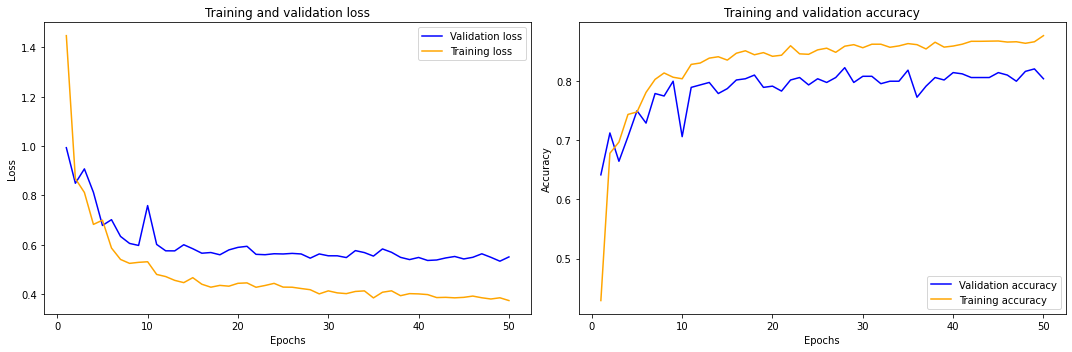

In [ ]:
batch_size = 64

train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/64)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
transfer_model.trainable = False
model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 0.40

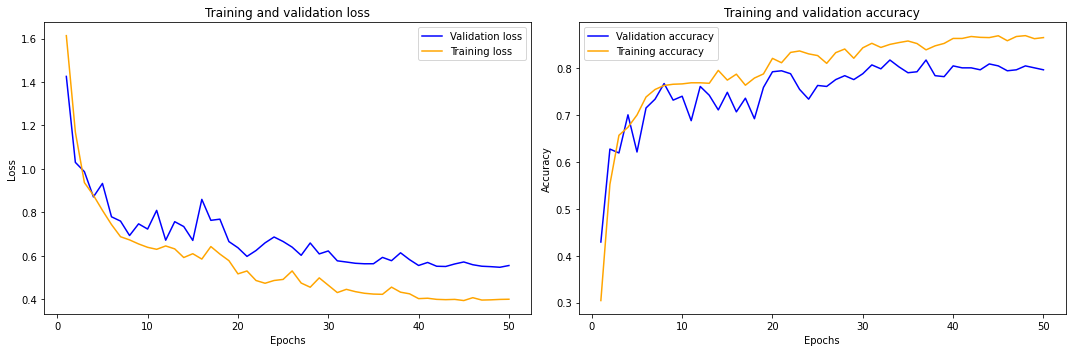

In [ ]:
batch_size = 256

train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/256)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
transfer_model.trainable = False
model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

The difference in validation accuracy between batch sizes is small. The batch size mostly influences "jumpness" of the plots. We decide to stick to the default batch size of 128.  
The overfit starts to occur from around 25 epochs. We can try to prevent it with regularization. For that we use l2-method.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 32.138  Accuracy: 0.829
Validation
Loss: 32.039  Accuracy: 0.804


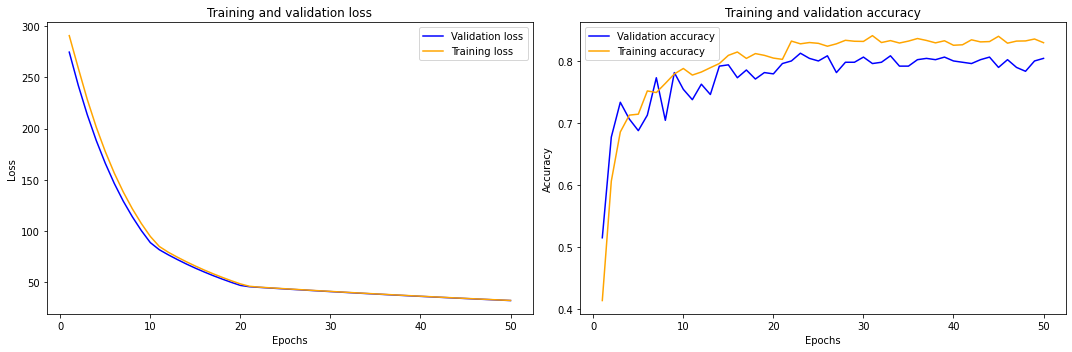

In [ ]:
batch_size = 128
regularization = 0.1

train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
transfer_model.trainable = False
model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

The diifference between training and validation decreased but te accuracy was also affected. It seems that we are reaching limit of learning abilities of our network for this data set.  
To further improve accuracy we may try to train some extra layers of VGG16. We start from only the last layer.
#### Dense layers + 1 convulation layer

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 29,105,669
Non-trainable params: 12,354,880
_________________________________________________________________
Final statistics
Training
Loss: 0.212  Accuracy: 0.935
Validation
Loss: 0.445  Accuracy: 0.846


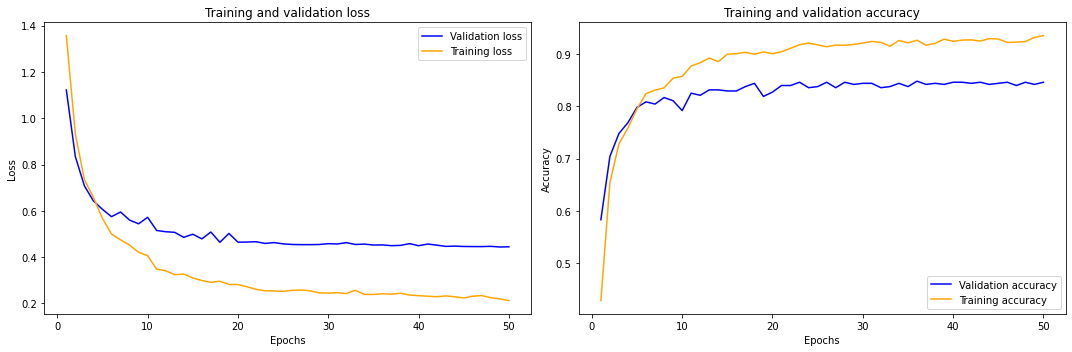

In [ ]:
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
train_from = 17

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

Number of trainable parameters increased by over 2 milions. This allowed for improvement of test and validation accuracy up to 93.5% and 84.6% respectively.

#### Dense layers + 2 convulation layers
Let's further increase the number of trainable layers untill we notice overfitting and reaching limits of our data set.

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 31,465,477
Non-trainable params: 9,995,072
_________________________________________________________________
Final statistics
Training
Loss: 0.150

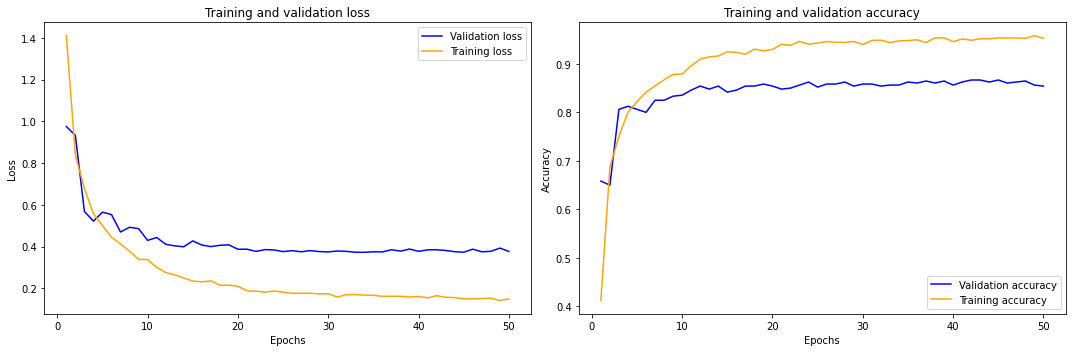

In [ ]:
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
train_from = 16

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

#### Dense layers + 3 convulation layers

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 33,825,285
Non-trainable params: 7,635,264
_________________________________________________________________
Final statistics
Training
Loss: 0.074  Accuracy: 0.981
Validation
Loss: 0.343  Accuracy: 0.885


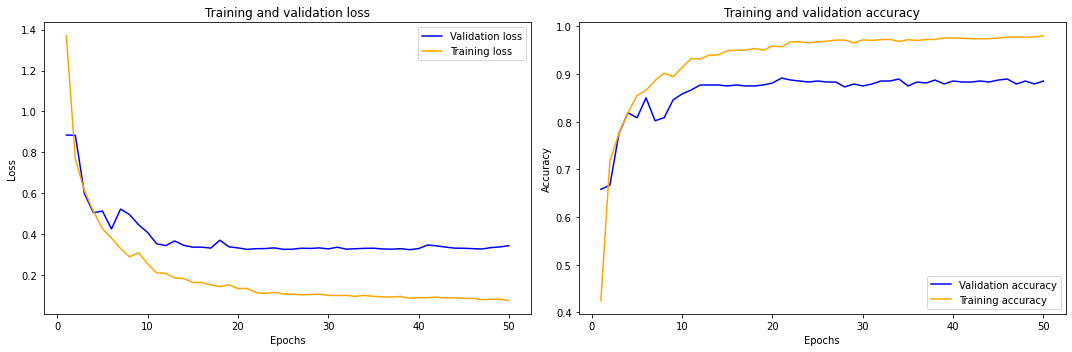

In [ ]:
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
train_from = 15

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

#### Dense layers + 4 convulation layers
There seem to be still some room for improvement. Let's further increase the number of trainable layers.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 36,185,093
Non-trainable params: 5,275,456
_________________________________________________________________
Final statistics
Training
Loss: 0.049  Accuracy: 0.986
Validation
Loss: 0.280  Accuracy: 0.915


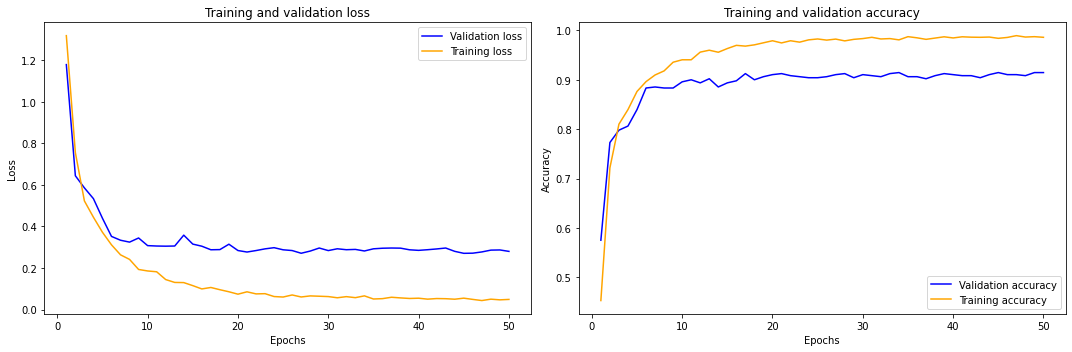

In [ ]:
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
#13 because 14 is MaxPooling
train_from = 13

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

#### Dense layers + 5 convulation layers
There seem to be still some room for improvement. Let's further increase the number of trainable layers.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 38,544,901
Non-trainable params: 2,915,648
_________________________________________________________________
Final statistics
Training
Loss: 0.028  Accuracy: 0.995
Validation
Loss: 0.286  Accuracy: 0.921


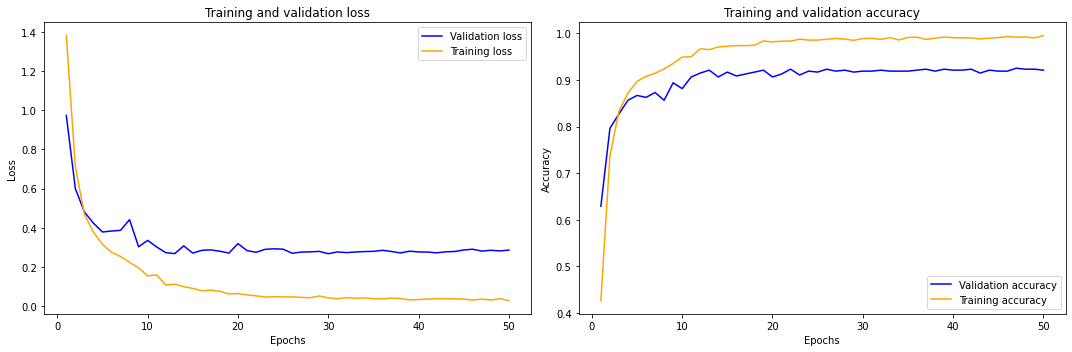

In [ ]:
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
#13 because 14 is MaxPooling
train_from = 12

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

#### Dense layers + 5 convulation layers - learning rate
Increasing the number of convulation layers to 5 gave a lot of improvement. We decide to fine-tune model with 5 trainable convulation layers. First we check if increasing learning rate a little helps.

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 38,544,901
Non-trainable params: 2,915,648
_________________________________________________________________
Final statistics
Training
Loss: 0.013  Accuracy: 0.996
Validation
Loss: 0.378  Accuracy: 0.908


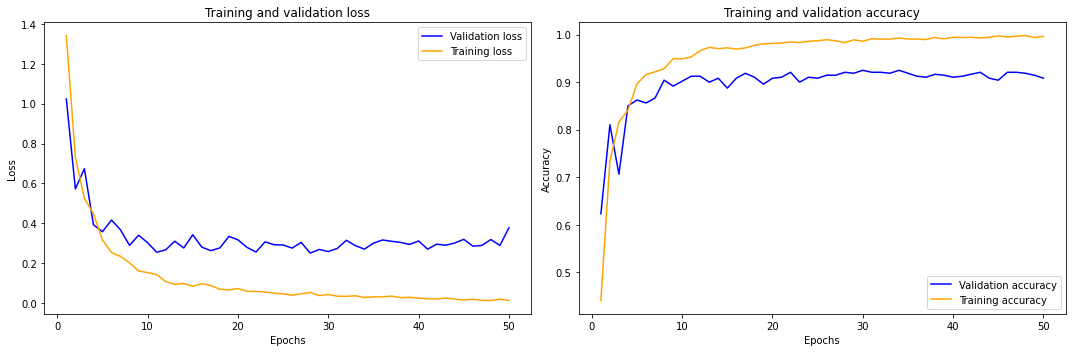

In [ ]:
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps],
    [1e-3, 5e-4]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
train_from = 12

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

The validation accuracy didn't improve so we stick to the previous learning rate.
#### Dense layers + 5 convulation layers - regularization
To reduce difference in accuracy between train and validation we apply regularization. We do it with l2 approach.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 38,544,901
Non-trainable params: 2,915,648
_________________________________________________________________
Final statistics
Training
Loss: 31.497  Accuracy: 0.982
Validation
Loss: 31.487  Accuracy: 0.904


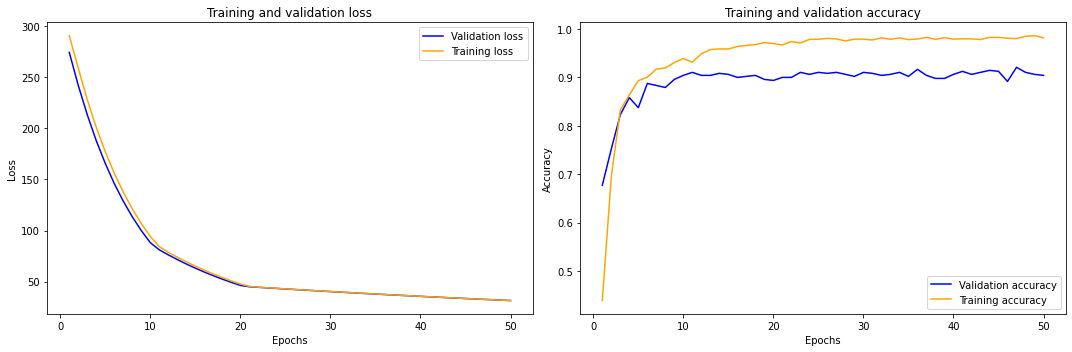

In [ ]:
regularization = 0.1
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
train_from = 12

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 38,544,901
Non-trainable params: 2,915,648
_________________________________________________________________
Final statistics
Training
Loss: 23.981  Accuracy: 0.991
Validation
Loss: 24.222  Accuracy: 0.904


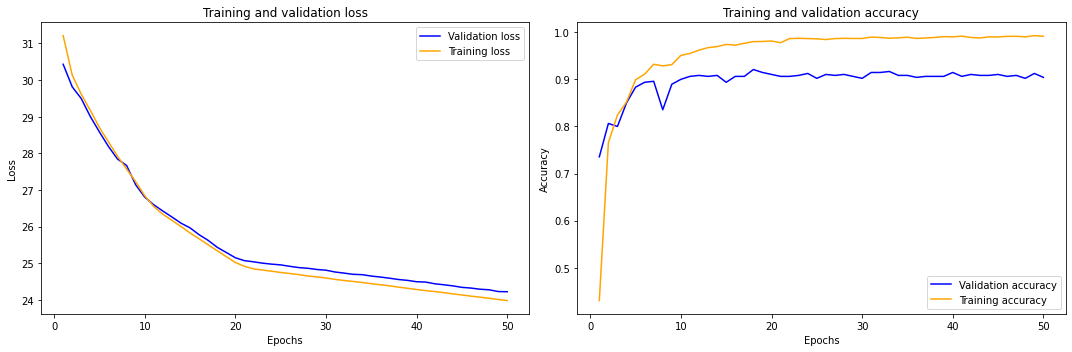

In [ ]:
regularization = 0.01
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
train_from = 12

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 38,544,901
Non-trainable params: 2,915,648
_________________________________________________________________
Final statistics
Training
Loss: 2.960  Accuracy: 0.992
Validation
Loss: 3.193  Accuracy: 0.919


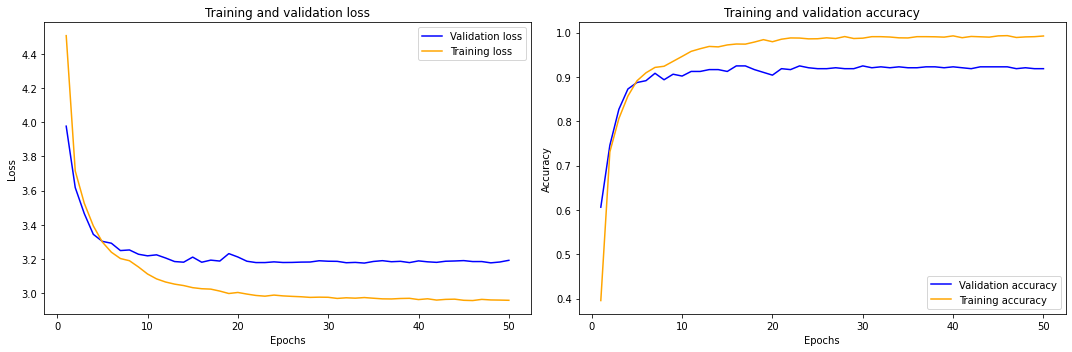

In [ ]:
regularization = 0.001
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
train_from = 12

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

#### Dense layers + 6 convulation layers
Regularization did not help. Let's check 6 convulation layers.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_14 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 39,725,061
Non-trainable params: 1,735,488
_________________________________________________________________
Final statistics
Training
Loss: 0.025  Accuracy: 0.994
Validation
Loss: 0.239  Accuracy: 0.917


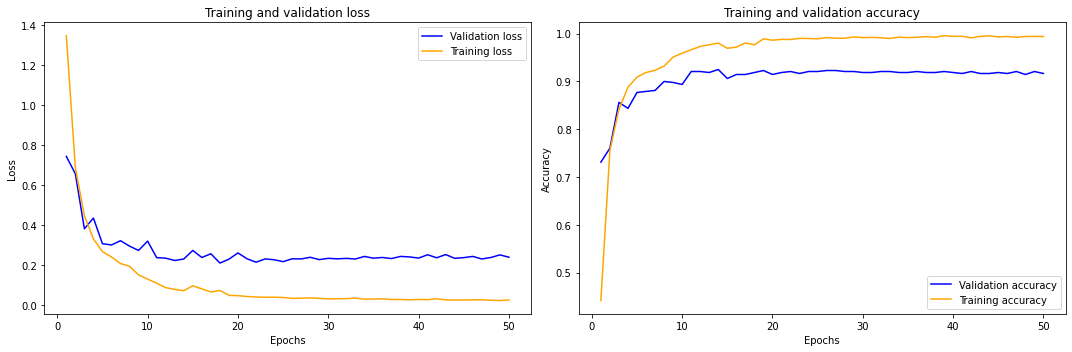

In [ ]:
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
#13 because 14 is MaxPooling
train_from = 11

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

#### Dense layers + 7 convulation layers
Finally let's see 7.

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_15 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_43 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 40,315,141
Non-trainable params: 1,145,408
_________________________________________________________________
Final statistics
Training
Loss: 0.019  Accuracy: 0.996
Validation
Loss: 0.261  Accuracy: 0.913


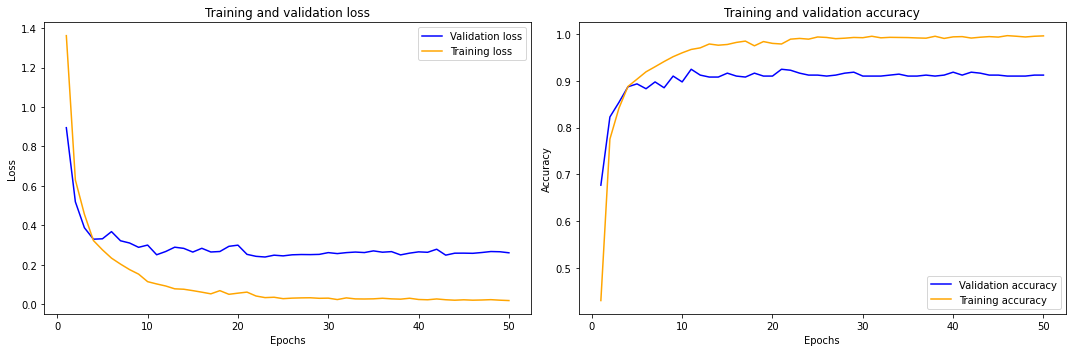

In [ ]:
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
#13 because 14 is MaxPooling
train_from = 9

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

And we can also try it with regularization.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_14 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 39,725,061
Non-trainable params: 1,735,488
_________________________________________________________________
Final statistics
Training
Loss: 0.025  Accuracy: 0.994
Validation
Loss: 0.239  Accuracy: 0.917


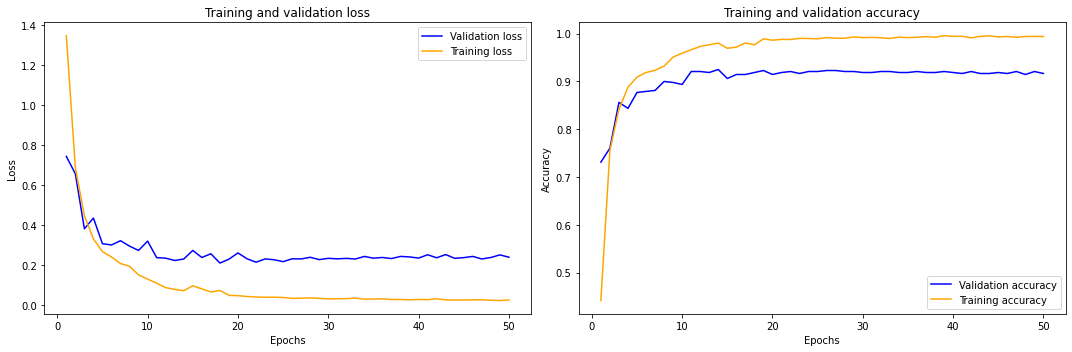

In [ ]:
regularization = 0.01
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
train_from = 9

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

### Validation split verification   
The best results were obtained for 5 trainable covulation layers with no regularization. We train this model one more time and verify it on validation split.

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 38,544,901
Non-trainable params: 2,915,648
_________________________________________________________________
Final statistics
Training
Loss: 0.032

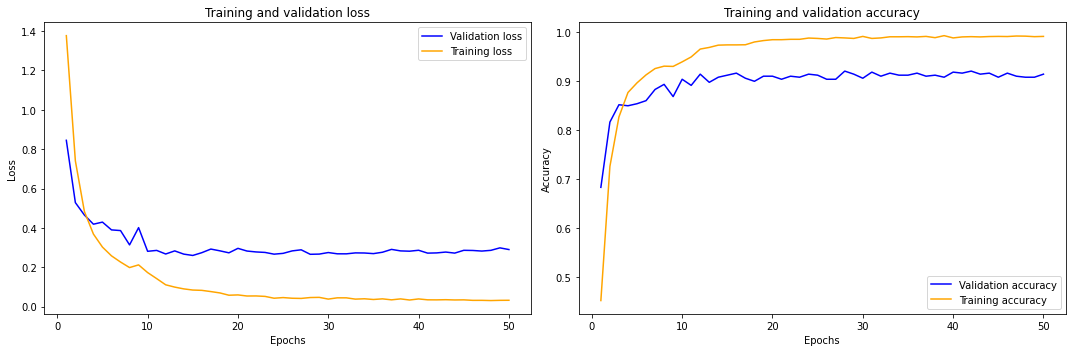

In [ ]:
batch_size = 128
train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)

num_steps = math.ceil(3865/128)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10*num_steps, 20*num_steps],
    [1e-3, 5e-4, 1e-4,]
    )

transfer_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
transfer_model.trainable = True
#13 because 14 is MaxPooling
train_from = 12

for layer in transfer_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(transfer_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              metrics=['accuracy'])
model.summary()

transfer_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(transfer_hist)

First let's evaluate it in general.

In [22]:
model.evaluate(valid_ds)

4/4 [==============================] - 3s 230ms/step - loss: 0.2898 - accuracy: 0.9146


[0.2898240387439728, 0.9145833253860474]

And now let's create a confusion matrix.

Number of mistakes by label:

{'drums': 4, 'guitar': 17, 'keyboard': 9, 'microphone': 3, 'saxophone': 8}


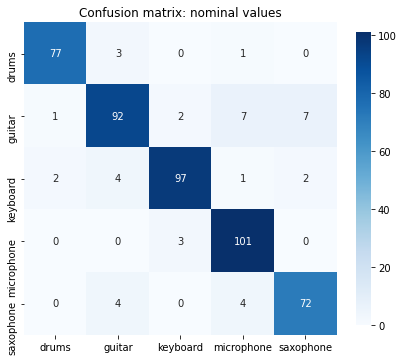

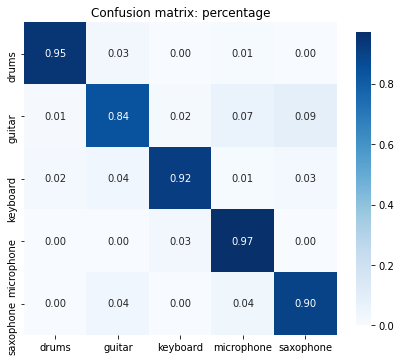

In [59]:
images = []
labels = []
for batch in valid_ds:
  images.append(batch[0]) 
  labels.append(batch[1]) 
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

pred = model.predict(images)
pred_lbl = np.argmax(pred, axis = 1)
val_lbl = np.argmax(labels, axis = 1)
def plot_conf(true, pred, norm = False):
  _ , ax = plt.subplots(figsize =(7, 6))
  conf = confusion_matrix(true, pred)
  fmt = 'd'
  ax_lbl = info.features['label'].names
  if norm:
    conf = conf.astype("float") / conf.sum(axis=1)
    fmt = '.2f'
    ax.set_title('Confusion matrix: percentage')
  else:
    ax.set_title('Confusion matrix: nominal values')
    mis = conf.sum(axis=1) - np.diag(conf)
    print("Number of mistakes by label:\n")
    print('{}'.format({a : b for a,b in zip(ax_lbl, mis)}))
  sns.heatmap(conf, xticklabels=ax_lbl, yticklabels=ax_lbl,
      cmap='Blues', annot=True, fmt=fmt, square=True, cbar_kws={'shrink':.9 },
      ax=ax)
  
plot_conf(val_lbl, pred_lbl)
plot_conf(val_lbl, pred_lbl, norm=True)

Most mistakes is done for guitar. It is often mistaken with microphone and saxophone. Improving of data set should focus on these three categories.  
Let's see some of the mistakes.

In [62]:
img_mis = images[pred_lbl != val_lbl]
pred_mis = pred_lbl[pred_lbl != val_lbl]
lbl_mis = val_lbl[pred_lbl != val_lbl]

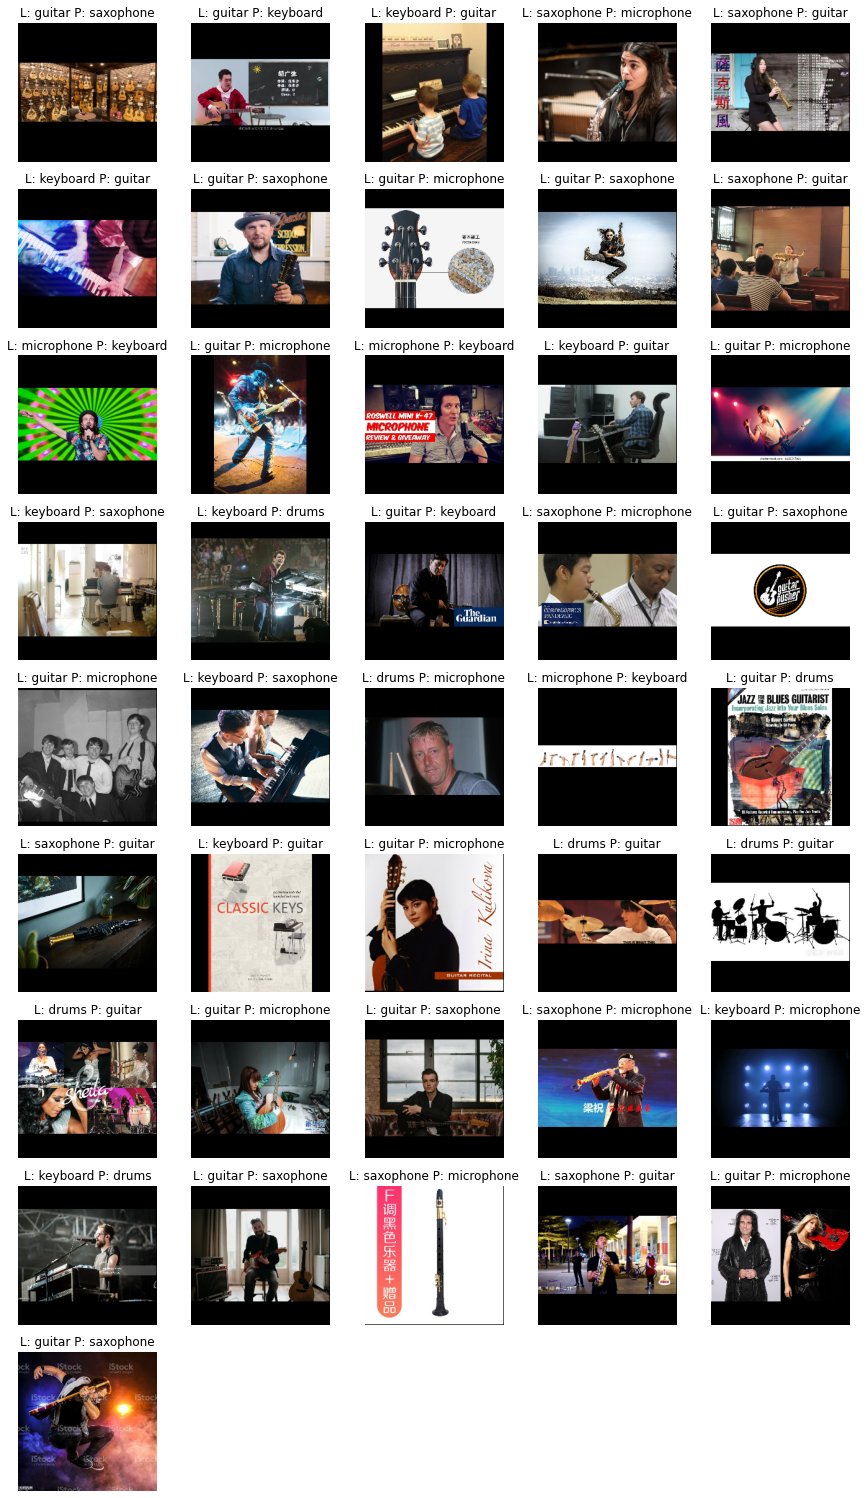

In [63]:
label_name = info.features['label'].names
def display_images(images, labels, predictions, cols=5):
  rows = int(math.ceil(len(images) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, label, pred) in enumerate(zip(images, labels, predictions)):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title("L: {} P: {}".format(label_name[int(label)], label_name[int(pred)]))
  
display_images(img_mis, lbl_mis, pred_mis)

Definetly accuracy could be improved by just gathering more data and mistakes are done for difficult examples. We have also more then one type of saxophone in a dataset what makes predictions even harder.  
### Test data verification
Finally let's see accuracy of our test data.

In [64]:
model.evaluate(test_ds)

4/4 [==============================] - 3s 230ms/step - loss: 0.3738 - accuracy: 0.9062


[0.37383684515953064, 0.90625]

Confusion matrix.

Number of mistakes by label:

{'drums': 9, 'guitar': 11, 'keyboard': 8, 'microphone': 6, 'saxophone': 11}


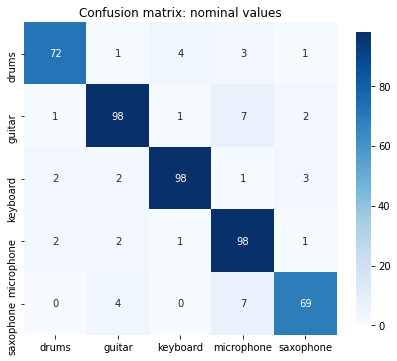

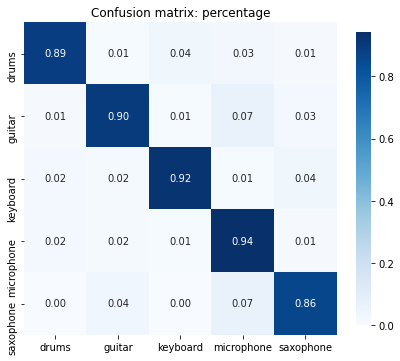

In [65]:
images = []
labels = []
for batch in test_ds:
  images.append(batch[0]) 
  labels.append(batch[1]) 
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

pred = model.predict(images)
pred_lbl = np.argmax(pred, axis = 1)
test_lbl = np.argmax(labels, axis = 1)
def plot_conf(true, pred, norm = False):
  _ , ax = plt.subplots(figsize =(7, 6))
  conf = confusion_matrix(true, pred)
  fmt = 'd'
  ax_lbl = info.features['label'].names
  if norm:
    conf = conf.astype("float") / conf.sum(axis=1)
    fmt = '.2f'
    ax.set_title('Confusion matrix: percentage')
  else:
    ax.set_title('Confusion matrix: nominal values')
    mis = conf.sum(axis=1) - np.diag(conf)
    print("Number of mistakes by label:\n")
    print('{}'.format({a : b for a,b in zip(ax_lbl, mis)}))
  sns.heatmap(conf, xticklabels=ax_lbl, yticklabels=ax_lbl,
      cmap='Blues', annot=True, fmt=fmt, square=True, cbar_kws={'shrink':.9 },
      ax=ax)
  
plot_conf(test_lbl, pred_lbl)
plot_conf(test_lbl, pred_lbl, norm=True)

Similar accuracy and mistakes can be observed so representation of our data by validation and test is satisfactory.  
As mentioned improvement of the model should mostly focus on gathering more images. Nevertheless, almost 5000 images provided us accuracy of over 90% which a good result.